In [1]:
import pandas
import numpy

from matplotlib import pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

plot_scale = "log"
nbins = 31
kernel_w = 0.04


raw_fr = pandas.read_csv(
    "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/true_firing_rate/raw_fr.csv"
)

flt_fr = raw_fr.loc[raw_fr["experiment"].apply(lambda _x: _x in ["GT", "NS"])]
flt_log = flt_fr.copy(); flt_log["firing rate"] = numpy.log10(flt_log["firing rate"])


/gpfs/bbp.cscs.ch/home/reimann/venvs/bpsnap/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [2]:
fr_bins = numpy.linspace(0, 10., nbins)
log_bins = numpy.linspace(-3, 1, nbins)

def gaussian_kernel_estimate(bins, rel_width):
    from scipy.stats import norm
    w = rel_width * (bins[-1] - bins[0])
    kernel = norm(0, w)
    bin_c = 0.5 * (bins[:-1] + bins[1:])
    def func(pts):
        ret = [kernel.pdf(bin_c - _pt) for _pt in pts]
        ret = numpy.nansum(numpy.vstack([_ret / _ret.sum() for _ret in ret]), axis=0)
        return pandas.Series(ret, index=bin_c)
    
    return func

fr_df = flt_fr.groupby(["experiment", "layer"])["firing rate"].apply(
    gaussian_kernel_estimate(fr_bins, kernel_w)
)
log_df = flt_log.groupby(["experiment", "layer"])["firing rate"].apply(
    gaussian_kernel_estimate(log_bins, kernel_w)
)

if plot_scale == "log":
    use_fr = flt_log
    use_df = log_df
else:
    use_fr = flt_fr
    use_df = fr_df
    
p_df = use_df.unstack("experiment").apply(lambda _row: _row["NS"]/(1E-1+_row["GT"]), axis=1).unstack("layer")

min_fr = use_fr.groupby(["layer"])["firing rate"].min()
max_fr = use_fr.groupby(["layer"])["firing rate"].max()
for col in min_fr.index:
    mn = min_fr[col]; mx = max_fr[col]
    p_df[col].loc[p_df.index < mn] = numpy.NaN
    p_df[col].loc[p_df.index > mx] = numpy.NaN
    

/nvme/reimann/2417575/ipykernel_248468/3148239908.py:11: RuntimeWarning: invalid value encountered in divide
  ret = numpy.nansum(numpy.vstack([_ret / _ret.sum() for _ret in ret]), axis=0)


In [3]:
def estimate_average_ratio_bootstrap(smpls, n=100, m=100, func_agg=numpy.nanmean, func_cmp=lambda x, y: x/y):
    estimates = []
    smpls_a = numpy.array(smpls["GT"]); smpls_b = numpy.array(smpls["NS"])
    smpls_a = smpls_a[~numpy.isinf(smpls_a)]; smpls_b = smpls_b[~numpy.isinf(smpls_b)]
    for _ in range(n):
        a = numpy.random.choice(smpls_a, m)
        b = numpy.random.choice(smpls_b, m)
        estimates.append(func_cmp(func_agg(a), func_agg(b)))
    estimates = numpy.array(estimates); estimates = estimates[~numpy.isnan(estimates)]
    return pandas.Series({"5th": numpy.percentile(estimates, 5), "mean": numpy.mean(estimates),
                  "95th": numpy.percentile(estimates, 95)})

overest_df = flt_fr.groupby(["experiment", "layer"])["firing rate"].apply(list).unstack("experiment")
overest_df = overest_df.apply(estimate_average_ratio_bootstrap, axis=1, func_agg=numpy.nanmean)

overest_log = flt_log.groupby(["experiment", "layer"])["firing rate"].apply(list).unstack("experiment")
overest_log = overest_log.apply(estimate_average_ratio_bootstrap, axis=1, func_agg=numpy.nanmean, func_cmp=lambda x,y:x-y)

overest_pooled = estimate_average_ratio_bootstrap(flt_fr.set_index("experiment")["firing rate"],
                                 func_agg=numpy.nanmean)
overest_pooled_log = estimate_average_ratio_bootstrap(flt_log.set_index("experiment")["firing rate"],
                                 func_agg=numpy.nanmean, func_cmp=lambda x,y:x-y)

5th     0.153147
mean    0.221041
95th    0.305067
dtype: float64


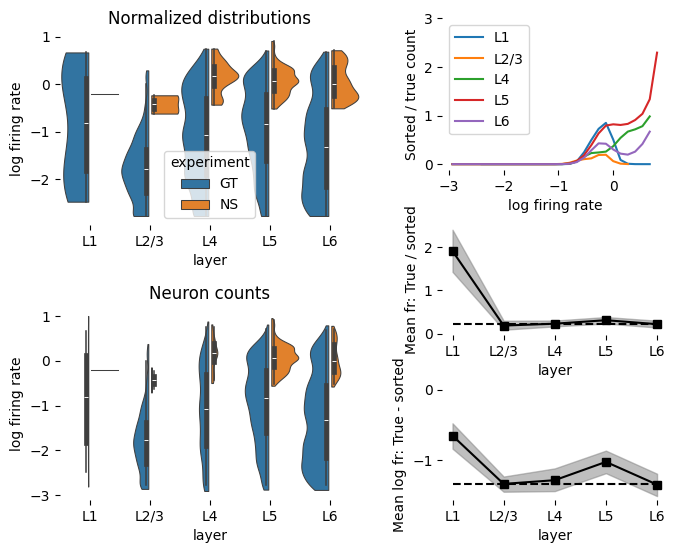

In [4]:
import seaborn

fig = plt.figure(figsize=(7.5, 5.5))

layout = [
    [0.05, 0.55, 0.4, 0.35],
    [0.05, 0.05, 0.4, 0.35],
    [0.56, 0.65, 0.3, 0.275],
    [0.56, 0.35, 0.3, 0.2],
    [0.56, 0.05, 0.3, 0.2]
]

ax = fig.add_axes(layout[0])
seaborn.violinplot(use_fr, x="layer", y="firing rate", split=True, hue="experiment", gap=.1,
                  width=1., linewidth=0.75, common_norm=False, density_norm="width", cut=0,
                  bw_adjust=0.75)
if plot_scale == "log":
    ax.set_ylabel("log firing rate")
ax.set_title("Normalized distributions")
ax.set_frame_on(False)

ax = fig.add_axes(layout[1])
seaborn.violinplot(use_fr, x="layer", y="firing rate", split=True, hue="experiment", gap=.1,
                  width=1., linewidth=0.75, common_norm=False, density_norm="count", cut=0.5,
                  bw_adjust=0.75, legend=None)
if plot_scale == "log":
    ax.set_ylabel("log firing rate")
ax.set_title("Neuron counts")
ax.set_frame_on(False)

ax = fig.add_axes(layout[2])

for i, col in enumerate(p_df.columns):
    ax.plot(p_df[col].index, p_df[col].values, label=col)

plt.legend()
ax.set_yticks([0, 1, 2, 3])
ax.set_frame_on(False)
if plot_scale == "log":
    ax.set_xlabel("log firing rate")
else:
    ax.set_xlabel("firing rate")
ax.set_ylabel("Sorted / true count")

ax = fig.add_axes(layout[3])
patches = []
x_vals = numpy.arange(len(overest_df.index)) 
polygon = Polygon(numpy.vstack([numpy.hstack([x_vals, x_vals[::-1]]),
                                numpy.hstack([overest_df["5th"].values, overest_df["95th"][::-1]])
                               ]).transpose(),
                          closed=True)
patches.append(polygon)
coll = PatchCollection(patches, alpha=0.5, color="grey")
ax.add_collection(coll)
ax.plot(x_vals, overest_df["mean"], marker="s", color="black")
ax.plot(x_vals, overest_pooled["mean"] * numpy.ones_like(x_vals),
       color="black", ls="--")
# ax.plot([x_vals[0], x_vals[-1]], [1, 1], color="grey", ls=":")
ax.set_xticks(x_vals)
ax.set_xticklabels(overest_df.index)
ax.set_frame_on(False)
ax.set_ylabel("Mean fr: True / sorted")
ax.set_xlabel("layer")

ax = fig.add_axes(layout[4])
patches = []
x_vals = numpy.arange(len(overest_log.index)) 
polygon = Polygon(numpy.vstack([numpy.hstack([x_vals, x_vals[::-1]]),
                                numpy.hstack([overest_log["5th"].values, overest_log["95th"][::-1]])
                               ]).transpose(),
                          closed=True)
patches.append(polygon)
coll = PatchCollection(patches, alpha=0.5, color="grey")
ax.add_collection(coll)
ax.plot(x_vals, overest_log["mean"], marker="s", color="black")
ax.plot(x_vals, overest_pooled_log["mean"] * numpy.ones_like(x_vals),
       color="black", ls="--")
# ax.plot([x_vals[0], x_vals[-1]], [0, 0], color="black", ls="--")
ax.set_ylim([ax.get_ylim()[0], 0])
ax.set_xticks(x_vals)
ax.set_xticklabels(overest_df.index)
ax.set_frame_on(False)
ax.set_ylabel("Mean log fr: True - sorted")
ax.set_xlabel("layer")

print(overest_pooled)